# Offline Replayer Evaluation II - Recogym small
> Running recogym for offline simulation and evaluation with small number of users and items

- toc: true
- badges: true
- comments: true
- categories: [bandit]
- image: 

## Environment setup

In [3]:
!pip install -q recogym

In [31]:
import numpy as np
from numpy.random.mtrand import RandomState
from scipy.special import logsumexp
import scipy
import pandas as pd
from scipy.stats.distributions import beta
from copy import deepcopy

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

from itertools import chain
from sklearn.neighbors import NearestNeighbors
from IPython.display import display, HTML

from matplotlib.ticker import FormatStrFormatter

import gym, recogym
from recogym import env_1_args, Configuration
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
from recogym.agents.organic_count import OrganicCount, organic_count_args, to_categorical
from recogym import Configuration
from recogym.agents import Agent
from recogym.envs.observation import Observation
from recogym.agents import RandomAgent, random_args
from recogym import verify_agents, verify_agents_IPS
from recogym.evaluate_agent import plot_verify_agents, verify_agents_recall_at_k

from recogym.envs.session import OrganicSessions
from recogym.envs.context import DefaultContext
from recogym.envs.observation import Observation

import matplotlib.pyplot as plt
%matplotlib inline

P = 50 # Number of Products
U = 50 # Number of Users

In [32]:
# You can overwrite environment arguments here
env_1_args['random_seed'] = 42
env_1_args['num_products']= P
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=P//2
env_1_args['sigma_mu_organic'] = 0.1
env_1_args['sigma_omega']=0.05

In [33]:
# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [34]:
env.reset()

In [35]:
# Generate RecSys logs for U users
reco_log = env.generate_logs(U)
reco_log.head(20)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 44.55it/s]


,t,u,z,v,a,c,ps,ps-a
0,0.0,0,organic,6,<NA>,NaN,NaN,None
1,1.0,0,organic,6,<NA>,NaN,NaN,None
2,2.0,0,organic,31,<NA>,NaN,NaN,None
3,3.0,0,organic,2,<NA>,NaN,NaN,None
4,4.0,0,organic,31,<NA>,NaN,NaN,None
5,5.0,0,organic,32,<NA>,NaN,NaN,None
6,6.0,0,organic,1,<NA>,NaN,NaN,None
7,7.0,0,bandit,<NA>,23,0.0,0.02,()
8,8.0,0,bandit,<NA>,10,0.0,0.02,()
9,9.0,0,bandit,<NA>,34,0.0,0.02,()


In [36]:
n_events = reco_log.shape[0]
n_organic = reco_log.loc[reco_log['z'] == 'organic'].shape[0]
print('Training on {0} organic and {1} bandit events'.format(n_organic, n_events - n_organic))

Training on 1117 organic and 3926 bandit events


## Defining evaluation methods

### Traditional evaluation

In [37]:
def leave_one_out(reco_log, agent, last = False, N = 1, folds = 10):
    # 1. Extract all organic events
    reco_log = reco_log.loc[reco_log['z'] == 'organic']
    
    # 2. For every user sequence - randomly sample out an item
    hits = []
    for _ in range(folds):
        user_id = 0
        history = []
        session = OrganicSessions()
        agent.reset()
        for row in reco_log.itertuples():
            # If we have a new user
            if row.u != user_id:
                if last:
                    # Sample out last item
                    index = len(history) - 1
                else:
                    # Sample out a random item from the history
                    index = np.random.choice(len(history),
                                             replace = False)
                test  = history[index]
                train = history[:index] + history[index + 1:]

                # 3. Recreate the user sequence without these items - Let the agent observe the incomplete sequence
                for t, v in list(train):
                    session.next(DefaultContext(t, user_id), int(v))

                # 4. Generate a top-N set of recommendations by letting the agent act
                # TODO - For now only works for N = 1
                try:
                    prob_a = agent.act(Observation(DefaultContext(t + 1, user_id), session), 0, False)['ps-a']
                except:
                    prob_a = [1 / P] * P

                # 5. Compute metrics checking whether the sampled test item is in the top-N
                try:
                  hits.append(np.argmax(prob_a) == int(test[1]))
                except:
                  hits.append(0)

                # Reset variables
                user_id = row.u
                history = []
                session = OrganicSessions()
                agent.reset()

            # Save the organic interaction to the running average for the session
            history.append((row.t,row.v))
    
    # Error analysis
    mean_hits = np.mean(hits)
    serr_hits = np.std(hits) / np.sqrt(len(hits))
    low_bound = mean_hits - 1.96 * serr_hits
    upp_bound = mean_hits + 1.96 * serr_hits
    
    return mean_hits, low_bound, upp_bound

def verify_agents_traditional(reco_log, agents, last = False, N = 1, folds = 10):
    # Placeholder DataFrame for result
    stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }

    # For every agent
    for agent_id in agents:
        # Compute HR@k
        mean, low, upp = leave_one_out(reco_log, agents[agent_id], last = last, N = N, folds = folds)
        stat['Agent'].append(agent_id)
        stat['0.025'].append(low)
        stat['0.500'].append(mean)
        stat['0.975'].append(upp)
    return pd.DataFrame().from_dict(stat)

### Counterfactual evaluation

In [38]:
def compute_ips_weights(agent, reco_log):
    # Placeholder for return values
    rewards = [] # Labels for actions
    t_props = [] # Treatment propensities
    l_props = [] # Logging propensities
    
    # For every logged interaction
    user_id = 0
    session = OrganicSessions()
    agent.reset()
    for row in reco_log.itertuples():
        # If we have a new user
        if row.u != user_id:
            # Reset
            session = OrganicSessions()
            agent.reset()
            user_id = row.u
        
        # If we have an organic event
        if row.z == 'organic':
            session.next(DefaultContext(row.t, row.u), int(row.v))        
            
        else:
            prob_a = agent.act(Observation(DefaultContext(row.t, row.u), session), 0, False)['ps-a']
            rewards.append(row.c)
            try:
              t_props.append(prob_a[int(row.a)])
            except:
              t_props.append(0)
            l_props.append(row.ps)
            session = OrganicSessions()
    
    return np.asarray(rewards), np.asarray(t_props), np.asarray(l_props)

def verify_agents_counterfactual(reco_log, agents, cap = 3):
    # Placeholder DataFrame for results
    IPS_stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }
    CIPS_stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }
    SNIPS_stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }

    # For every agent
    for agent_id in agents:
        # Get the rewards and propensities
        rewards, t_props, l_props = compute_ips_weights(agents[agent_id], reco_log)
        
        # Compute the sample weights - propensity ratios
        p_ratio = t_props / l_props

        # Effective sample size for E_t estimate (from A. Owen)
        n_e = len(rewards) * (np.mean(p_ratio) ** 2) / (p_ratio ** 2).mean()
        n_e = 0 if np.isnan(n_e) else n_e
        print("Effective sample size for agent {} is {}".format(str(agent_id), n_e))
        
        # Critical value from t-distribution as we have unknown variance
        alpha = .00125
        cv = scipy.stats.t.ppf(1 - alpha, df = int(n_e) - 1)
        
        ###############
        # VANILLA IPS #
        ###############
        # Expected reward for pi_t
        E_t = np.mean(rewards * p_ratio)

        # Variance of the estimate
        var = ((rewards * p_ratio - E_t) ** 2).mean()
        stddev = np.sqrt(var)
        
        # C.I. assuming unknown variance - use t-distribution and effective sample size
        min_bound = E_t - cv * stddev / np.sqrt(int(n_e))
        max_bound = E_t + cv * stddev / np.sqrt(int(n_e))
        
        # Store result
        IPS_stat['Agent'].append(agent_id)
        IPS_stat['0.025'].append(min_bound)
        IPS_stat['0.500'].append(E_t)
        IPS_stat['0.975'].append(max_bound)
        
        ############## 
        # CAPPED IPS #
        ##############
        # Cap ratios
        p_ratio_capped = np.clip(p_ratio, a_min = None, a_max = cap)
        
        # Expected reward for pi_t
        E_t_capped = np.mean(rewards * p_ratio_capped)

        # Variance of the estimate
        var_capped = ((rewards * p_ratio_capped - E_t_capped) ** 2).mean()
        stddev_capped = np.sqrt(var_capped)        
        
        # C.I. assuming unknown variance - use t-distribution and effective sample size
        min_bound_capped = E_t_capped - cv * stddev_capped / np.sqrt(int(n_e))
        max_bound_capped = E_t_capped + cv * stddev_capped / np.sqrt(int(n_e))
        
        # Store result
        CIPS_stat['Agent'].append(agent_id)
        CIPS_stat['0.025'].append(min_bound_capped)
        CIPS_stat['0.500'].append(E_t_capped)
        CIPS_stat['0.975'].append(max_bound_capped)
        
        ##############
        # NORMED IPS #
        ##############
        # Expected reward for pi_t
        E_t_normed = np.sum(rewards * p_ratio) / np.sum(p_ratio)

        # Variance of the estimate
        var_normed = np.sum(((rewards - E_t_normed) ** 2) * (p_ratio ** 2)) / (p_ratio.sum() ** 2)    
        stddev_normed = np.sqrt(var_normed)

        # C.I. assuming unknown variance - use t-distribution and effective sample size
        min_bound_normed = E_t_normed - cv * stddev_normed / np.sqrt(int(n_e))
        max_bound_normed = E_t_normed + cv * stddev_normed / np.sqrt(int(n_e))

        # Store result
        SNIPS_stat['Agent'].append(agent_id)
        SNIPS_stat['0.025'].append(min_bound_normed)
        SNIPS_stat['0.500'].append(E_t_normed)
        SNIPS_stat['0.975'].append(max_bound_normed)
        
    return pd.DataFrame().from_dict(IPS_stat), pd.DataFrame().from_dict(CIPS_stat), pd.DataFrame().from_dict(SNIPS_stat)

## Creating agents

### SVD agent

In [39]:
class SVDAgent(Agent):
    def __init__(self, config, U = U, P = P, K = 5):
        super(SVDAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        assert(P >= K)
        self.K = K
        self.R = csr_matrix((U,P))
        self.V = np.zeros((P,K))
        self.user_history = np.zeros(P)
    
    def train(self, reco_log, U = U, P = P):
        # Extract all organic user logs
        reco_log = reco_log.loc[reco_log['z'] == 'organic']
        
        # Generate ratings matrix for training, row-based for efficient row (user) retrieval
        self.R = csr_matrix((np.ones(len(reco_log)),
                            (reco_log['u'],reco_log['v'])),
                            (U,P))

        # Singular Value Decomposition
        _, _, self.V = svds(self.R, k = self.K)
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_history[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        scores = self.user_history.dot(self.V.T).dot(self.V)
        action = np.argmax(scores)
        prob = np.zeros_like(scores)
        prob[action] = 1.0

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_history = np.zeros(P)

### Item-KNN agent

In [40]:
class itemkNNAgent(Agent):
    def __init__(self, config, U = U, P = P, k = 5, greedy = False, alpha = 1):
        super(itemkNNAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        self.k = min(P,k)
        self.greedy = greedy
        self.alpha = alpha
        self.Rt = csr_matrix((P,U))
        self.user_history = np.zeros(P)
        self.S = np.eye(P)
    
    def train(self, reco_log, U = U, P = P):
        # Extract all organic user logs
        reco_log = reco_log.loc[reco_log['z'] == 'organic']
        
        # Generate ratings matrix for training, row-based for efficient row (user) retrieval
        self.R_t = csr_matrix((np.ones(len(reco_log)),
                              (reco_log['v'],reco_log['u'])),
                              (P,U))

        # Set up nearest neighbours module
        nn = NearestNeighbors(n_neighbors = self.k,
                              metric = 'cosine')

        # Initialise placeholder for distances and indices
        distances = []
        indices   = []

        # Dirty fix for multiprocessing backend being unable to pickle large objects
        nn.fit(self.R_t)
        distances, indices = nn.kneighbors(self.R_t, return_distance = True)

        # Precompute similarity matrix S
        data = list(chain.from_iterable(1.0 - distances))
        rows = list(chain.from_iterable([i] * self.k for i in range(P)))
        cols = list(chain.from_iterable(indices))
        
        # (P,P)-matrix with cosine similarities between items
        self.S = csr_matrix((data,(rows, cols)), (P,P)).todense()
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_history[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        scores = self.user_history.dot(self.S).A1
        
        if self.greedy:
            action = np.argmax(scores)
            prob = np.zeros_like(scores)
            prob[action] = 1.0
        else:
            scores **= self.alpha
            prob = scores / np.sum(scores)
            action = self.rng.choice(self.S.shape[0], p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_history = np.zeros(P)

### User-KNN agent

In [41]:
class userkNNAgent(Agent):
    def __init__(self, config, U = U, P = P, k = 5, greedy = False, alpha = 1):
        super(userkNNAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        self.k = min(P,k)
        self.greedy = greedy
        self.alpha = alpha
        self.U = U
        self.P = P
        self.R = csr_matrix((U,P))
        self.user_history = np.zeros(P)
        self.nn = NearestNeighbors(n_neighbors = self.k, metric = 'cosine')
        
    def train(self, reco_log, U = U, P = P):
        # Extract all organic user logs
        reco_log = reco_log.loc[reco_log['z'] == 'organic']
        
        # Generate ratings matrix for training, row-based for efficient row (user) retrieval
        self.R = csr_matrix((np.ones(len(reco_log)),
                            (reco_log['u'],reco_log['v'])),
                            (U,P))

        # Fit nearest neighbours
        self.nn.fit(self.R)
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_history[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        
        # Get neighbouring users based on user history
        distances, indices = self.nn.kneighbors(self.user_history.reshape(1,-1))
        scores = np.add.reduce([dist * self.R[idx,:] for dist, idx in zip(distances,indices)])
        
        if self.greedy:
            action = np.argmax(scores)
            prob = np.zeros_like(scores)
            prob[action] = 1.0
        else:
            scores **= self.alpha
            prob = scores / np.sum(scores)
            action = self.rng.choice(self.P, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_history = np.zeros(P)

### Agent initializations

In [45]:
# SVD Agent
SVD_agent = SVDAgent(Configuration(env_1_args), U, P, 30)

# item-kNN Agent
itemkNN_agent = itemkNNAgent(Configuration(env_1_args), U, P, 500, greedy = True)

# user-kNN Agent
userkNN_agent = userkNNAgent(Configuration(env_1_args), U, P, 20, greedy = True)

# Generalised Popularity agent
GPOP_agent = OrganicCount(Configuration({
    **env_1_args,
    'select_randomly': True,
}))

# Generalised Popularity agent
GPOP_agent_greedy = OrganicCount(Configuration({
    **env_1_args,
    'select_randomly': False,
}))

# Peronalised Popularity agent
PPOP_agent = OrganicUserEventCounterAgent(Configuration({
    **organic_user_count_args,
    **env_1_args,
    'select_randomly': True,
}))

# Peronalised Popularity agent
PPOP_agent_greedy = OrganicUserEventCounterAgent(Configuration({
    **organic_user_count_args,
    **env_1_args,
    'select_randomly': False,
}))

# Random Agent
random_args['num_products'] = P
RAND_agent = RandomAgent(Configuration({**env_1_args, **random_args,}))

In [46]:
SVD_agent.train(reco_log)
itemkNN_agent.train(reco_log)
userkNN_agent.train(reco_log)

## Offline evaluation

### Generating test logs

In [47]:
%%time
# Placeholder for agents
agents = {
    '    Random': RAND_agent,
    '   Popular': GPOP_agent_greedy,
    '   User-pop': PPOP_agent,
    '  SVD':  SVD_agent,
    ' User-kNN': userkNN_agent,
    'Item-kNN': itemkNN_agent,
}
agent_ids = sorted(list(agents.keys()))#['SVD','GPOP','PPOP','RAND']
# Generate new logs, to be used for offline testing
n_test_users = 50 # U
test_log = env.generate_logs(n_test_users)
n_events = test_log.shape[0]
n_organic = test_log.loc[test_log['z'] == 'organic'].shape[0]
print('Testing on {0} organic and {1} bandit events'.format(n_organic, n_events - n_organic))

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 39.77it/s]

Testing on 1033 organic and 4264 bandit events
CPU times: user 1.29 s, sys: 75.4 ms, total: 1.36 s
Wall time: 1.3 s


### (Util) helper function to plot barchart

In [48]:
def plot_barchart(result, title, xlabel,  col = 'tab:red', figname = 'fig.eps', size = (6,2), fontsize = 12):
    fig, axes = plt.subplots(figsize = size)
    plt.title(title, size = fontsize)
    n_agents = len(result)
    yticks = np.arange(n_agents)
    mean = result['0.500']
    lower = result['0.500'] - result['0.025']
    upper = result['0.975'] - result['0.500']
    plt.barh(yticks,
             mean,
             height = .25,
             xerr  = (lower, upper),
             align = 'center',
             color = col,)
    plt.yticks(yticks, result['Agent'], size = fontsize)
    plt.xticks(size = fontsize)
    plt.xlabel(xlabel, size = fontsize)
    plt.xlim(.0,None)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.savefig(figname, bbox_inches = 'tight')
    plt.show()

### Leave-one-out evaluation

/usr/local/lib/python3.7/dist-packages/recogym/agents/organic_user_count.py:51: RuntimeWarning: invalid value encountered in true_divide
  action_proba = features / np.sum(features)


,Agent,0.025,0.500,0.975
0,Random,0.000000,0.000000,0.000000
1,Popular,0.000000,0.000000,0.000000
2,User-pop,0.000000,0.000000,0.000000
3,SVD,0.273181,0.314286,0.355390
4,User-kNN,0.080663,0.108163,0.135664
5,Item-kNN,0.261387,0.302041,0.342695


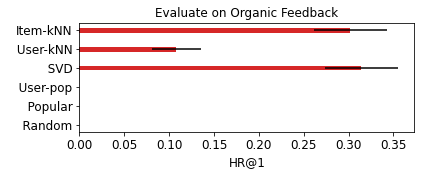

CPU times: user 1.5 s, sys: 61.4 ms, total: 1.56 s
Wall time: 1.53 s


In [49]:
%%time
result_LOO = verify_agents_traditional(test_log, deepcopy(agents))
display(result_LOO)
plot_barchart(result_LOO, 'Evaluate on Organic Feedback', 'HR@1', 'tab:red', 'traditional_eval.eps')

### IPS Estimators

In [50]:
# Generate new logs, to be used for offline testing
test_log_ppop = env.generate_logs(n_test_users, agent = deepcopy(PPOP_agent))

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 27.14it/s]


In [51]:
test_log_ppop.head()

,t,u,z,v,a,c,ps,ps-a
0,0.0,0,organic,7,<NA>,NaN,NaN,None
1,1.0,0,organic,9,<NA>,NaN,NaN,None
2,2.0,0,organic,7,<NA>,NaN,NaN,None
3,3.0,0,organic,20,<NA>,NaN,NaN,None
4,4.0,0,bandit,<NA>,20,0.0,0.25,()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in double_scalars


Effective sample size for agent     Random is 0
Effective sample size for agent    Popular is 0
Effective sample size for agent    User-pop is 0
Effective sample size for agent   SVD is 1120.7440758663975
Effective sample size for agent  User-kNN is 298.0127276763118
Effective sample size for agent Item-kNN is 889.7428242947079


,Agent,0.025,0.500,0.975
0,Random,NaN,0.000000,NaN
1,Popular,NaN,0.000000,NaN
2,User-pop,NaN,0.000000,NaN
3,SVD,-0.010231,0.014218,0.038666
4,User-kNN,-0.024978,0.005388,0.035754
5,Item-kNN,-0.011787,0.011767,0.035322


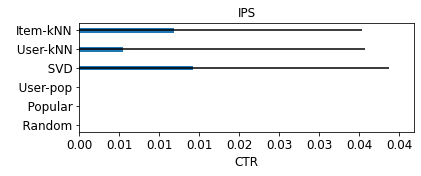

,Agent,0.025,0.500,0.975
0,Random,NaN,0.000000,NaN
1,Popular,NaN,0.000000,NaN
2,User-pop,NaN,0.000000,NaN
3,SVD,-0.010231,0.014218,0.038666
4,User-kNN,-0.024978,0.005388,0.035754
5,Item-kNN,-0.011787,0.011767,0.035322


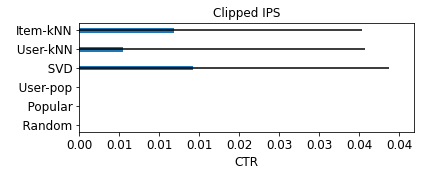

CPU times: user 5.97 s, sys: 120 ms, total: 6.09 s
Wall time: 6.03 s


In [52]:
%%time
cap = 15
result_IPS, result_CIPS, result_SNIPS = verify_agents_counterfactual(test_log_ppop, deepcopy(agents), cap = cap)
display(result_IPS)
plot_barchart(result_IPS, 'IPS', 'CTR', 'tab:blue', 'bandit_eval_noclip.eps')
display(result_CIPS)
plot_barchart(result_CIPS, 'Clipped IPS', 'CTR', 'tab:blue', 'bandit_eval_clip{0}.eps'.format(cap))

### A/B tests

In [53]:
n_test_users = 50 # U

agents = {
    '    Random': RAND_agent,
    '   Popular': GPOP_agent_greedy,
    '   User-pop': PPOP_agent,
    '  SVD':  SVD_agent,
    ' User-kNN': userkNN_agent,
    'Item-kNN': itemkNN_agent,
}

Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 36.23it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 41.71it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 28.04it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 35.95it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:06<00:00,  7.86it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|██████████| 50/50 [00:01<00:00, 33.91it/s]


,Agent,0.025,0.500,0.975
0,Random,0.007624,0.010324,0.013590
1,Popular,0.008203,0.010997,0.014357
2,User-pop,0.011879,0.015227,0.019140
3,SVD,0.012572,0.015994,0.019976
4,User-kNN,0.011999,0.015350,0.019263
5,Item-kNN,0.012174,0.015545,0.019477


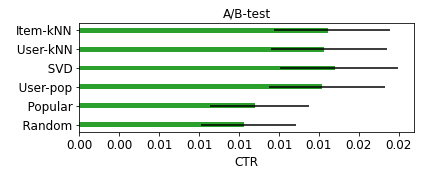

CPU times: user 14 s, sys: 445 ms, total: 14.4 s
Wall time: 14.1 s


In [54]:
%%time
result_AB = verify_agents(env, n_test_users, deepcopy(agents))
display(result_AB)
plot_barchart(result_AB, 'A/B-test', 'CTR', 'tab:green', 'ABtest_eval.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


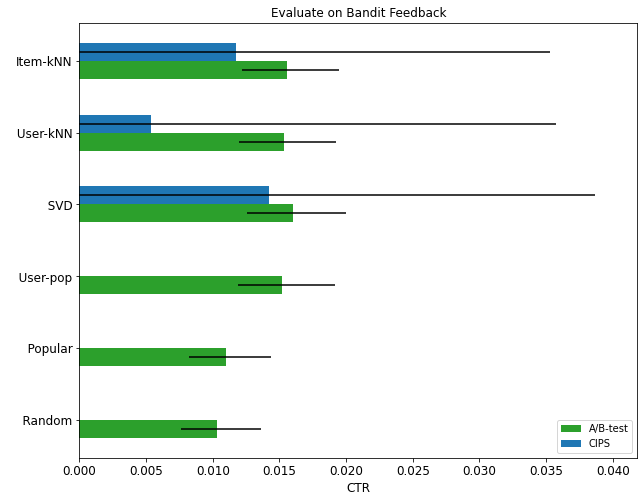

In [57]:
def combine_barchart(resultAB, resultCIPS, title, xlabel,  figname = 'fig.eps', size = (10,8), fontsize = 12):
    fig, axes = plt.subplots(figsize = size)
    plt.title(title, size = fontsize)
    n_agents = len(resultAB)
    
    for i, (name, colour, result) in enumerate([('A/B-test', 'tab:green', result_AB),('CIPS', 'tab:blue', result_CIPS)]):
        mean = result['0.500']
        lower = result['0.500'] - result['0.025']
        upper = result['0.975'] - result['0.500']
        height = .25
        yticks = [a + i * height for a in range(n_agents)]
        plt.barh(yticks,
                 mean,
                 height = height,
                 xerr  = (lower, upper),
                 align = 'edge',
                 label = name,
                 color = colour)
    plt.yticks(yticks, result['Agent'], size = fontsize)
    plt.xticks(size = fontsize)
    plt.xlabel(xlabel, size = fontsize)
    plt.legend(loc = 'lower right')
    plt.xlim(.0,None)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.savefig(figname, bbox_inches = 'tight')
    plt.show()
combine_barchart(result_AB, result_CIPS, 'Evaluate on Bandit Feedback', 'CTR', 'ABtest_CIPS.eps')

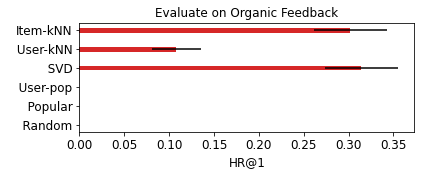

In [58]:
plot_barchart(result_LOO, 'Evaluate on Organic Feedback', 'HR@1', 'tab:red', 'traditional_eval.eps')